In [11]:
import requests
import time
from bs4 import BeautifulSoup
import random
import pandas as pd
import re
from IPython.display import display, HTML
import urllib.parse

# Job Scraping

In [ ]:
# Title of job in search
title = "Data Scientist"
encoded_job_title = title.replace(" ", "%2B")

# Location
location = "Los Angeles County"
encoded_location = location.replace(" ", "%2B")

# Start position, goes by 10
start_position = 0

# Number of jobs to search
num_jobs = 



In [13]:
# link for list of job postings on the left on linkedin

all_jobs = []

for start_position in range(0, num_jobs + 1, 10):
    list_url = f"https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords={encoded_job_title}&location={encoded_location}&geoId=&trk=public_jobs_jobs-search-bar_search-submit&start={start_position}"
    response = requests.get(list_url)

    if response.status_code == 200:
        list_data = response.text
        list_soup = BeautifulSoup(list_data, "html.parser")
        more_jobs = list_soup.find_all("li")
        all_jobs.extend(more_jobs)
    else:
        print(f"Failed to retrieve data for start_position={start_position}. Status code: {response.status_code}")
        break  

# Print the total number of jobs found
print(f"Total jobs found: {len(all_jobs)}")




Failed to retrieve data for start_position=1000. Status code: 400
Total jobs found: 999


In [14]:
job_id_list = []

for job in all_jobs:
    # find job_ids
    base_card_div = job.find("div", {"class": "base-card"})
    if base_card_div:  
        job_id = base_card_div.get("data-entity-urn", "")
        if job_id:
            job_id = job_id.split(":")[3]  # Extract ID
            job_id_list.append(job_id)
    else:
        continue
job_id_list = set(job_id_list)
print(len(job_id_list))

882


In [15]:
def clean_description(description):
    if description:
        description = description.text
        text = re.sub(r'([a-z])([A-Z])', r'\1 \2', description)
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text)
        
        # Trim leading and trailing spaces
        text = text.strip()

        return text
        


In [16]:
job_list = []

for job_id in job_id_list:
    job_url = f"https://www.linkedin.com/jobs-guest/jobs/api/jobPosting/{job_id}"
    job_response = requests.get(job_url)

    # Too many requests will cause error
    if job_response.status_code == 429:
        time.sleep(5)  # Wait for 60 seconds (or more based on LinkedIn's rate limit policy)
        job_response = requests.get(job_url)

    job_soup = BeautifulSoup(job_response.text, "html.parser")

    # Dictionary for each job posting
    job_post = {}
    
    # Clean description used to parse for fields
    raw_description = job_soup.find("div", {"class": "description__text description__text--rich"})
    cleaned_desc = clean_description(raw_description)

    # Check Response
    job_post["response"] = job_response.status_code

    # listing ID
    job_post["id"] = job_id
    
    # time posted
    try:
        job_post["time_posted"] = job_soup.find("span", {"class": "posted-time-ago__text topcard__flavor--metadata"}).text.strip()
    except:
        job_post["time_posted"] = None
    # company name
    try:
        job_post["company_name"] = job_soup.find("a",{"class": "topcard__org-name-link topcard__flavor--black-link"}).text.strip()
    except:
        job_post["company_name"] = None
    
    # company location
    try: 
        job_post["location"] = job_soup.find("span", {"class": "topcard__flavor topcard__flavor--bullet"}).text.strip()
    except:
        job_post["location"] = None
    
    # Role Title
    try:
        job_post["title"] = job_soup.find("h2", {"class":"top-card-layout__title font-sans text-lg papabear:text-xl font-bold leading-open text-color-text mb-0 topcard__title"}).text.strip()
    except:
        job_post["title"] = None

    # Seniority Level
    try:
        level_header = job_soup.find("h3", {"class": "description__job-criteria-subheader"})
        sen_level = level_header.find_next_sibling("span").text.strip()
        job_post["seniority_level"] = sen_level
    except:
        job_post["seniority_level"] = None
        
    # Employment Type (Fulltime, Part-time, internship)
    try:
        level_header = job_soup.find("h3", {"class": "description__job-criteria-subheader"})
        emp_header = level_header.find_next("h3", {"class": "description__job-criteria-subheader"})
        emp_type = emp_header.find_next_sibling("span").text.strip()
        job_post["employment_type"] = emp_type
        
    except:
        job_post["job_type"] = None

    # Job Function
    try:
        level_header = job_soup.find("h3", {"class": "description__job-criteria-subheader"})
        emp_header = level_header.find_next("h3", {"class": "description__job-criteria-subheader"})
        job_header = emp_header.find_next("h3", {"class": "description__job-criteria-subheader"})
        job_function = job_header.find_next_sibling("span").text.strip()
        job_post["job_function"] = job_function
        
    except:
        job_post["job_function"] = None
        
    # Industries
    try:
        level_header = job_soup.find("h3", {"class": "description__job-criteria-subheader"})
        emp_header = level_header.find_next("h3", {"class": "description__job-criteria-subheader"})
        job_header = emp_header.find_next("h3", {"class": "description__job-criteria-subheader"})
        industry_header = job_header.find_next("h3", {"class": "description__job-criteria-subheader"})
        industry = industry_header.find_next_sibling("span").text.strip()
        job_post["industry"] = industry

    except:
        job_post["job_type"] = "Job type not specified"
    
    # Years of Experience - Keep as given in description
    try:
        bullet_points = raw_description.find_all(["li", "p"])
        pattern = r'(\d+)\+?\s*years?\s*(?:of experience)?|(\d+)-(\d+)\s*years?\s*(?:of experience)?|(\d+)\s*years?\s*(?:of experience)?'

        matches = re.findall(pattern, cleaned_desc)
        yoe_bullets = []

        for bullet in bullet_points:
            text = bullet.get_text(strip=True)  
            if re.search(pattern, text):  
                yoe_bullets.append(text)

        job_post["yoe"] = yoe_bullets
    except:
        job_post["yoe"] = None

    # Degree Required - format as a list if mulitple degrees

    try:
        pattern = r"(?i)\b(bachelor[’']?s|master[’']?s|ph\.?d|doctorate|b\.?s\.?|m\.?s\.)\b"
        edu = re.findall(pattern, cleaned_desc)
        
        edu = [match.lower().replace("’", "'") for match in edu]
        degree_map = {"bs": "bachelor's", "ms": "master's", "b.s": "bachelor's", "m.s": "master's"}
        formatted_matches = [degree_map.get(match, match) for match in edu]
        degrees = list(set(formatted_matches))
        
        job_post["education"] = degrees
    except:
        job_post["education"] = None

    # Salary
    try:
        salary_div = job_soup.find("div", {"class": "salary compensation__salary"})
        if salary_div:  
            job_post["salary"] = salary_div.text.strip()
        else:
            if raw_description and hasattr(raw_description, 'text'):  # Check if raw_description is not None and has the 'text' attribute
                pattern = r"\$[\d,]+(?:\.\d{2})?\s?-\s?\$[\d,]+(?:\.\d{2})?"
                salary_range = re.findall(pattern, raw_description.text)
                job_post["salary"] = " ".join(salary_range) if salary_range else None
            else:
                job_post["salary"] = None

    except AttributeError as e:
        job_post["salary"] = None

    except:
        job_post["salary"] = None

    # Programming Languages (Python, R, SQL, Java, Scala)
    languages = ['python', 'r', 'sql', 'java', 'scala', 'c++', 'julia', 'matlab', 'dax', 'vba', 'mdx', 'javascript', 'typescript', 'bash', 'shell']

    try:
        pattern = r'\b(?:' + '|'.join(re.escape(lang) for lang in languages) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["programming_languages"] = None
        else:
            job_post["programming_languages"] = matches

    
    except:
        job_post["programming_languages"] = None


    # ML Skills (TensorFlow, PyTorch, Scikit-learn, Keras)
    ml_ai_skills = ['tensorflow', 'pytorch', 'scikit-learn', 'keras', 'xgboost', 'lightgbm', 'catboost', 'fastai', 'mlflow', 'onnx', 'apache mxnet', 
                'hugging face transformers', 'nltk', 'spacy', 'gensim', 'faiss', 'sentence-transformers', 'h2o.ai', 'deepchem', 
                'supervised learning', 'unsupervised learning', 'reinforcement learning', 'graph neural networks', 'computer vision', 
                'nlp', 'bayesian networks', 'logistic regression', 'linear regression', 'decision trees', 'random forest', 'gradient boosting', 
                'support vector machines', 'k-means clustering', 'hierarchical clustering', 'gaussian mixture models', 'hidden markov models', 
                'principal component analysis', 'singular value decomposition', 'time-series forecasting', 'anomaly detection', 'jax', 'genai', 'generativeai']

    try:
        
        pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in ml_ai_skills) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["ml_skills"] = None
        else:
            job_post["ml_skills"] = matches

    
    except:
        job_post["ml_skills"] = None

    # Data Processing & Databases (ETL, Pandas, Spark, Hadoop, Snowflake)
    data_processing_databases = ['etl', 'pandas', 'spark', 'hadoop', 'snowflake', 'airflow', 'dbt', 'kafka', 'redshift', 'bigquery', 'presto', 
                             'trino', 'hive', 'pig', 'databricks', 'delta lake', 'iceberg', 'hudi', 'cassandra', 'mongodb', 'couchdb', 
                             'neo4j', 'arangodb', 'firebase', 'postgresql', 'mysql', 'mariadb', 'sqlite', 'oracle', 'sql server', 
                             'teradata', 'vertica', 'clickhouse', 'greenplum', 'impala', 'exasol', 'druid', 'tidb', 'scyllaDB', 'rockset', 
                             'elasticsearch', 'splunk', 'opensearch', 'flink', 'beam', 'storm', 'dask', 'modin', 'ray[data]', 
                             'polars', 'duckdb', 'voltdb', 'timestream', 'timescaledb', 'influxdb', 'prometheus', 'graphdb', 
                             'yugabyte', 'foundationdb', 'faunadb', 'cosmos db', 'dynamodb']

    try:
        
        pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in data_processing_databases) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["data_processing_db"] = None
        else:
            job_post["data_processing_db"] = matches

    
    except:
        job_post["data_processing_db"] = None


    # Cloud Platforms (AWS, GCP, Azure, OCI)
    cloud_devops_platforms = ['aws', 'gcp', 'azure', 'oci', 'databricks', 'kubernetes', 'docker', 'terraform', 'cloudformation', 'ansible', 
                          'lambda', 'cloud run', 'sagemaker', 'vertex ai', 'azure ml', 'redshift spectrum', 'biglake', 'synapse', 
                          'athena', 'lake formation', 'snowpark', 'gitlab ci/cd', 'github actions', 'jenkins', 'circleci', 'argo workflows', 
                          'kubeflow', 'mlflow', 'airflow', 'dagster', 'prefect', 'kedro', 'bentoml', 'seldon', 'ray[serve]']

    try:
        
        pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in cloud_devops_platforms) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["cloud"] = None
        else:
            job_post["cloud"] = matches

    
    except:
        job_post["cloud"] = None

    # Visualization Tools (Tableau, Power BI, D3.js)
    visualization_tools = ['tableau', 'power bi', 'd3.js', 'looker', 'superset', 'metabase', 'plotly', 'matplotlib', 'seaborn', 'ggplot2', 
                       'altair', 'vega', 'dash', 'streamlit', 'shiny', 'holoviews', 'bokeh', 'oac']

    try:
        
        pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in visualization_tools) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["visualization"] = None
        else:
            job_post["visualization"] = matches

    
    except:
        job_post["data_processing_db"] = None

    # Big Data Tools (Airflow, Kafka, Kubernetes, Golang)
    big_data_tools = ['airflow', 'kafka', 'kubernetes', 'flink', 'storm', 'beam', 'pulsar', 'druid', 'clickhouse', 'redpanda', 'spark streaming', 'terraform']

    try:
        
        pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in big_data_tools) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["big_data"] = None
        else:
            job_post["big_data"] = matches

    
    except:
        job_post["big_data"] = None

    # product skills
    product_skills = ['a/b testing', 'a/b', 'experimentation', 'causal inference', 'growth analytics', 'product analytics', 
                  'feature engineering', 'model deployment', 'mlops', 'explainability', 'ai ethics', 'privacy-preserving ml']

    try:
        
        pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in product_skills) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["product_skills"] = None
        else:
            job_post["product_skills"] = matches

    
    except:
        job_post["product_skills"] = None

    # Description
    try:
        job_post["description"] = cleaned_desc
        
    except:
        job_post["description"] = None
    

    job_list.append(job_post)

In [17]:
jobs_df = pd.DataFrame(job_list)
jobs_df


,response,id,time_posted,company_name,location,title,seniority_level,employment_type,job_function,industry,...,salary,programming_languages,ml_skills,data_processing_db,cloud,visualization,big_data,product_skills,description,job_type
0,200,4124393297,2 months ago,Miso Robotics,"Pasadena, CA",Join Team Miso,Entry level,Full-time,Other,Automation Machinery Manufacturing,...,None,None,None,None,None,None,None,None,join the team at miso robotics at miso robotic...,NaN
1,200,4186605071,1 week ago,Safeway,"Phoenix, AZ",Sr. Data Scientist,Mid-Senior level,Full-time,Engineering and Information Technology,Retail,...,None,"[sql, python]",[nlp],"[hadoop, databricks, spark, snowflake]","[databricks, azure]",None,None,None,about the company albertsons companies is at t...,NaN
2,200,4048846517,2 days ago,BuildOps,"Los Angeles, CA",Backend Engineer,Entry level,Full-time,Engineering and Information Technology,Software Development,...,"$120,000.00/yr - $180,000.00/yr","[python, java]",None,None,None,None,None,None,at build ops were building a groundbreaking so...,NaN
3,200,3811190388,2 weeks ago,Cedars-Sinai,"Los Angeles, CA",Clinical Research Data Spec I - Smidt Heart In...,Not Applicable,Full-time,Other,"Hospitals and Health Care, IT Services and IT ...",...,$23.39/hr - $39.76/hr,"[r, python, sql]",[tensorflow],None,None,None,None,None,job description grow your career at cedarssina...,NaN
4,200,4160983481,4 days ago,FIGS,"Santa Monica, CA","Software Engineer, Backend",Entry level,Full-time,Engineering and Information Technology,Retail Apparel and Fashion,...,"$150,000.00/yr - $165,000.00/yr",[java],None,None,"[kubernetes, aws, terraform]",None,"[kubernetes, terraform]",None,figs is on the lookout for a software engineer...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,200,4066440893,5 days ago,Riot Games,"Los Angeles, CA","Integration Specialist, Enterprise",Not Applicable,Full-time,Project Management and Information Technology,"Computer Games, Software Development, and Tech...",...,"$153,800.00/yr - $216,200.00/yr","[sql, python, javascript]",None,"[oracle, kafka]",None,None,[kafka],None,riot games enterprise functions enable us to k...,NaN
878,200,4075135122,5 days ago,Metropolis Technologies,"Los Angeles, CA","Senior Software Engineer, Backend",Mid-Senior level,Full-time,Engineering and Information Technology,Consumer Services and Facilities Services,...,"$155,000.00/yr - $185,000.00/yr","[sql, scala, java]",[computer vision],[kafka],[kubernetes],None,"[kubernetes, kafka]",None,the company metropolis is an artificial intell...,NaN
879,200,4180635028,1 week ago,X4 Life Sciences,"Los Angeles, CA",Firmware Engineer,Mid-Senior level,Part-time,"Engineering, Science, and Other",Medical Equipment Manufacturing,...,None,None,None,None,None,None,None,None,firmware engineer nordic expert parttime labas...,NaN
880,200,4083690535,4 months ago,K2 Space Corporation,"Los Angeles, CA",Software Engineer,Entry level,Full-time,Engineering and Information Technology,Defense and Space Manufacturing,...,"$118,700.00/yr - $200,000.00/yr",[python],None,None,None,None,None,None,the role the software team at k2 strives to bl...,NaN


In [18]:
jobs_df.to_excel(f'job_postings_{title}_{location}.xlsx', index=False)


In [19]:
jobs_df[jobs_df['id']== '4120825586']['salary']

65    $70.67/yr - $208,000.00/yr
Name: salary, dtype: object

### TESTING

In [20]:

test_id = 4183174306
url = f"https://www.linkedin.com/jobs-guest/jobs/api/jobPosting/{test_id}"
job_response = requests.get(url)
test_soup = BeautifulSoup(job_response.text, "html.parser")
raw_description = test_soup.find("div", {"class": "description__text description__text--rich"})
cleaned_desc = clean_description(raw_description)

# YOE
# try:

#     bullet_points = raw_description.find_all(["li", "p"])
#     pattern = r'(\d+)\+?\s*years?\s*(?:of experience)?|(\d+)-(\d+)\s*years?\s*(?:of experience)?|(\d+)\s*years?\s*(?:of experience)?'

#     matches = re.findall(pattern, cleaned_desc)
#     yoe_bullets = []

#     for bullet in bullet_points:
#         text = bullet.get_text(strip=True)  
#         text = text.replace("\u202f", " ")
#         text = text.replace("\u2002f", " ")
#         if re.search(pattern, text):  
#             yoe_bullets.append(text)

#     print(yoe_bullets)
# except:
#     print(None)

# Salary
try:
    salary_div = test_soup.find("div", {"class": "salary compensation__salary"})
    if salary_div:  
        job_post["salary"] = salary_div.text.strip()
    else:
        if raw_description and hasattr(raw_description, 'text'):  # Check if raw_description is not None and has the 'text' attribute
            pattern = r"\$[\d,]+(?:\.\d{2})?\s?-\s?\$[\d,]+(?:\.\d{2})?"
            salary_range = re.findall(pattern, raw_description.text)
            print(" ".join(salary_range)) if salary_range else print(None)
        else:
            print(None)

except AttributeError as e:
    print(None)

except:
    print(None)


$140,8000 - $193,000


# Data PreProcessing

In [100]:
import math

job_data_df = jobs_df.copy()
job_data_df.head(5)

,response,id,time_posted (days),company_name,location,title,seniority_level,employment_type,job_function,industry,...,salary,programming_languages,ml_skills,data_processing_db,cloud,visualization,big_data,product_skills,description,job_type
0,200,4124393297,0,Miso Robotics,"Pasadena, CA",Join Team Miso,Entry level,Full-time,Other,Automation Machinery Manufacturing,...,None,None,None,None,None,None,None,None,join the team at miso robotics at miso robotic...,NaN
1,200,4186605071,0,Safeway,"Phoenix, AZ",Sr. Data Scientist,Mid-Senior level,Full-time,Engineering and Information Technology,Retail,...,None,"[sql, python]",[nlp],"[hadoop, databricks, spark, snowflake]","[databricks, azure]",None,None,None,about the company albertsons companies is at t...,NaN
2,200,4048846517,0,BuildOps,"Los Angeles, CA",Backend Engineer,Entry level,Full-time,Engineering and Information Technology,Software Development,...,"$120,000.00/yr - $180,000.00/yr","[python, java]",None,None,None,None,None,None,at build ops were building a groundbreaking so...,NaN
3,200,3811190388,0,Cedars-Sinai,"Los Angeles, CA",Clinical Research Data Spec I - Smidt Heart In...,Not Applicable,Full-time,Other,"Hospitals and Health Care, IT Services and IT ...",...,$23.39/hr - $39.76/hr,"[r, python, sql]",[tensorflow],None,None,None,None,None,job description grow your career at cedarssina...,NaN
4,200,4160983481,0,FIGS,"Santa Monica, CA","Software Engineer, Backend",Entry level,Full-time,Engineering and Information Technology,Retail Apparel and Fashion,...,"$150,000.00/yr - $165,000.00/yr",[java],None,None,"[kubernetes, aws, terraform]",None,"[kubernetes, terraform]",None,figs is on the lookout for a software engineer...,NaN


##### Salary - Replace with the average value if a range is provided, integer type

In [90]:
# Convert salary into just minimum if it is a range


# should eventually fix to detect "hr, hour, month, year, etc."
def extract_avg_range(salary):
    try:
        salary = str(salary).lower().replace(',', '').replace('$', '').strip()

        salaries = []
        
        single_values = re.findall(r'\d+(?:\.\d+)?', salary)  # Extract all numbers in string
        salaries = [int(float(val) * 52 * 40) if float(val) < 1000 else int(float(val)) for val in single_values]

        return int(math.floor(sum(salaries) / len(salaries)))
    except Exception as e:
        return 0
# ex_salary = "$160,000.00/yr - $200,000.00/yr"
# print(extract_avg_range(ex_salary))

# Replaces the None values with 0
job_data_df['salary'] = job_data_df['salary'].fillna('0')
job_data_df['salary'] = job_data_df['salary'].apply(extract_avg_range)

job_data_df.head(3)

,response,id,time_posted (days),company_name,location,title,seniority_level,employment_type,job_function,industry,...,salary,programming_languages,ml_skills,data_processing_db,cloud,visualization,big_data,product_skills,description,job_type
0,200,4124393297,0,Miso Robotics,"Pasadena, CA",Join Team Miso,Entry level,Full-time,Other,Automation Machinery Manufacturing,...,0,None,None,None,None,None,None,None,join the team at miso robotics at miso robotic...,NaN
1,200,4186605071,0,Safeway,"Phoenix, AZ",Sr. Data Scientist,Mid-Senior level,Full-time,Engineering and Information Technology,Retail,...,0,"[sql, python]",[nlp],"[hadoop, databricks, spark, snowflake]","[databricks, azure]",None,None,None,about the company albertsons companies is at t...,NaN
2,200,4048846517,0,BuildOps,"Los Angeles, CA",Backend Engineer,Entry level,Full-time,Engineering and Information Technology,Software Development,...,150000,"[python, java]",None,None,None,None,None,None,at build ops were building a groundbreaking so...,NaN


##### Reformat time_posted to days

In [101]:
# Format Time Posted to days

def convert_to_days(time_posted):
    
    time_string = time_posted.split(' ')
    if len(time_string) < 2:
        return 0
    date = time_string[1]
    num = int(time_string[0])
    if date == 'hour' or date == 'hours':
        return 1
    elif date == 'year' or date == 'years':
        return num * 365
    elif date == 'months' or date == 'months':
        return num * 30
    elif date == 'week' or date == 'weeks':
        return num * 7
    else:
        return num
   

jobs_df = jobs_df.rename(columns = {'time_posted': 'time_posted (days)'})
jobs_df['time_posted (days)'] = jobs_df['time_posted (days)'].fillna('0').astype(str)
jobs_df.loc[:, 'time_posted (days)'] = jobs_df['time_posted (days)'].apply(convert_to_days).astype(int)
jobs_df.head(1)




/var/folders/4p/b0r7rdfn5rn__y6drcc8f5m80000gn/T/ipykernel_58953/159974864.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  jobs_df['time_posted (days)'] = jobs_df['time_posted (days)'].fillna('0').astype(str)


,response,id,time_posted (days),company_name,location,title,seniority_level,employment_type,job_function,industry,...,salary,programming_languages,ml_skills,data_processing_db,cloud,visualization,big_data,product_skills,description,job_type
0,200,4124393297,0,Miso Robotics,"Pasadena, CA",Join Team Miso,Entry level,Full-time,Other,Automation Machinery Manufacturing,...,None,None,None,None,None,None,None,None,join the team at miso robotics at miso robotic...,NaN


##### Extract numbers from YOE desc, and return the average

In [102]:
import math 

def find_average_yoe(yoe):
    try:
        matches = re.findall(r'\d+\.?\d*', yoe)
        if matches:
            years = list(map(int, matches))
            years = [year for year in years if year < 20 & year != 18]
            if years:
                avg = sum(years) / len(years)
                return int(math.floor(avg)) if avg.is_integer() else int(avg)
        else:
            return 0 
    except:
        return 0

# test_yoe = None
# print(find_average_yoe(test_yoe))
job_data_df['yoe'] = job_data_df['yoe'].fillna('0')
job_data_df['yoe'] = job_data_df['yoe'].astype(str).apply(find_average_yoe)
job_data_df.head(1)

,response,id,time_posted (days),company_name,location,title,seniority_level,employment_type,job_function,industry,...,salary,programming_languages,ml_skills,data_processing_db,cloud,visualization,big_data,product_skills,description,job_type
0,200,4124393297,0,Miso Robotics,"Pasadena, CA",Join Team Miso,Entry level,Full-time,Other,Automation Machinery Manufacturing,...,None,None,None,None,None,None,None,None,join the team at miso robotics at miso robotic...,NaN


##### Remove Response column

In [103]:
job_data_df = job_data_df.drop('response', axis = 1)
job_data_df.head(1)

,id,time_posted (days),company_name,location,title,seniority_level,employment_type,job_function,industry,yoe,...,salary,programming_languages,ml_skills,data_processing_db,cloud,visualization,big_data,product_skills,description,job_type
0,4124393297,0,Miso Robotics,"Pasadena, CA",Join Team Miso,Entry level,Full-time,Other,Automation Machinery Manufacturing,0.0,...,None,None,None,None,None,None,None,None,join the team at miso robotics at miso robotic...,NaN


In [79]:
job_data_df.to_excel(f'job_postings_{title}_{location}_clean.xlsx', index=False)


# Job Output Analysis

In [35]:
import matplotlib.pyplot as plt

In [81]:
job_data_df.head(1)


,id,time_posted (days),company_name,location,title,seniority_level,employment_type,job_function,industry,yoe,...,salary,programming_languages,ml_skills,data_processing_db,cloud,visualization,big_data,product_skills,description,job_type
0,4124393297,0,Miso Robotics,"Pasadena, CA",Join Team Miso,Entry level,Full-time,Other,Automation Machinery Manufacturing,0.0,...,0,None,None,None,None,None,None,None,join the team at miso robotics at miso robotic...,NaN


### Salary

In [104]:
# 60 - 250
salary_df = job_data_df[job_data_df['salary'] != 0]

min_salary = salary_df['salary'].min()
max_salary = salary_df['salary'].max()

salary_df['salary'].hist(bins = 20, range=(min_salary,max_salary + 20000), edgecolor='black', alpha=0.7, figsize=(10, 6))
avg_salary = salary_df['salary'].mean()
med_salary = salary_df['salary'].median()

plt.axvline(avg_salary, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {avg_salary:,.0f}')
plt.axvline(med_salary, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {med_salary:,.0f}')

plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.title("Salary Distribution")

plt.legend(loc='upper right')

plt.show()

TypeError: '<=' not supported between instances of 'float' and 'str'

### Salary vs YOE

TypeError: 'value' must be an instance of str or bytes, not a None

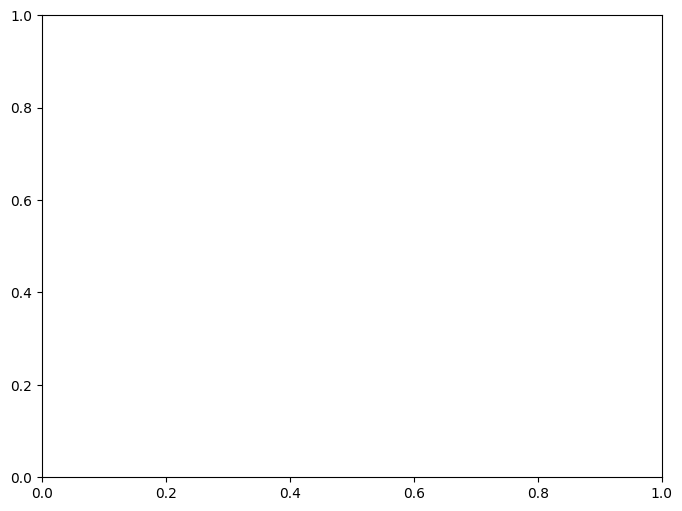

In [105]:
# Filter the data
salary_yoe_df = job_data_df[(job_data_df['yoe'] != 0) & (job_data_df['salary'] != 0)].reset_index(drop=True)

# Create the scatter plot
plt.figure(figsize=(8, 6))

# Scatter plot with a logarithmic scale for the salary axis
plt.scatter(job_data_df['yoe'], job_data_df['salary'], color='blue', alpha=0.6)

# Set axis limits to make the plot more readable
plt.xlim(0, 12)  # Years of Experience range (0-12)
plt.ylim(min_salary, max_salary)  # Salary range (from 1000 to 350,000)

# Apply a logarithmic scale to the y-axis for salary (helps with large variations)

# Adding grid, title, and labels
plt.title('Salary vs Years of Experience', fontsize=14)
plt.xlabel('Years of Experience', fontsize=12)
plt.ylabel('Salary', fontsize=12)

# Add grid for better visibility
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()